##Emotsiooniskooride arvutamine

Selles etapis toimub kasvatusväärtusi sisaldavate tekstide emotsiooniskooride arvutamine. Protsessijoonisel on näha tegevused, mis viiakse läbi antud etapis. Koodi parema loetavuse huvides on analüüsi osa paigutatud järgmisesse, kuuendasse osasse. 

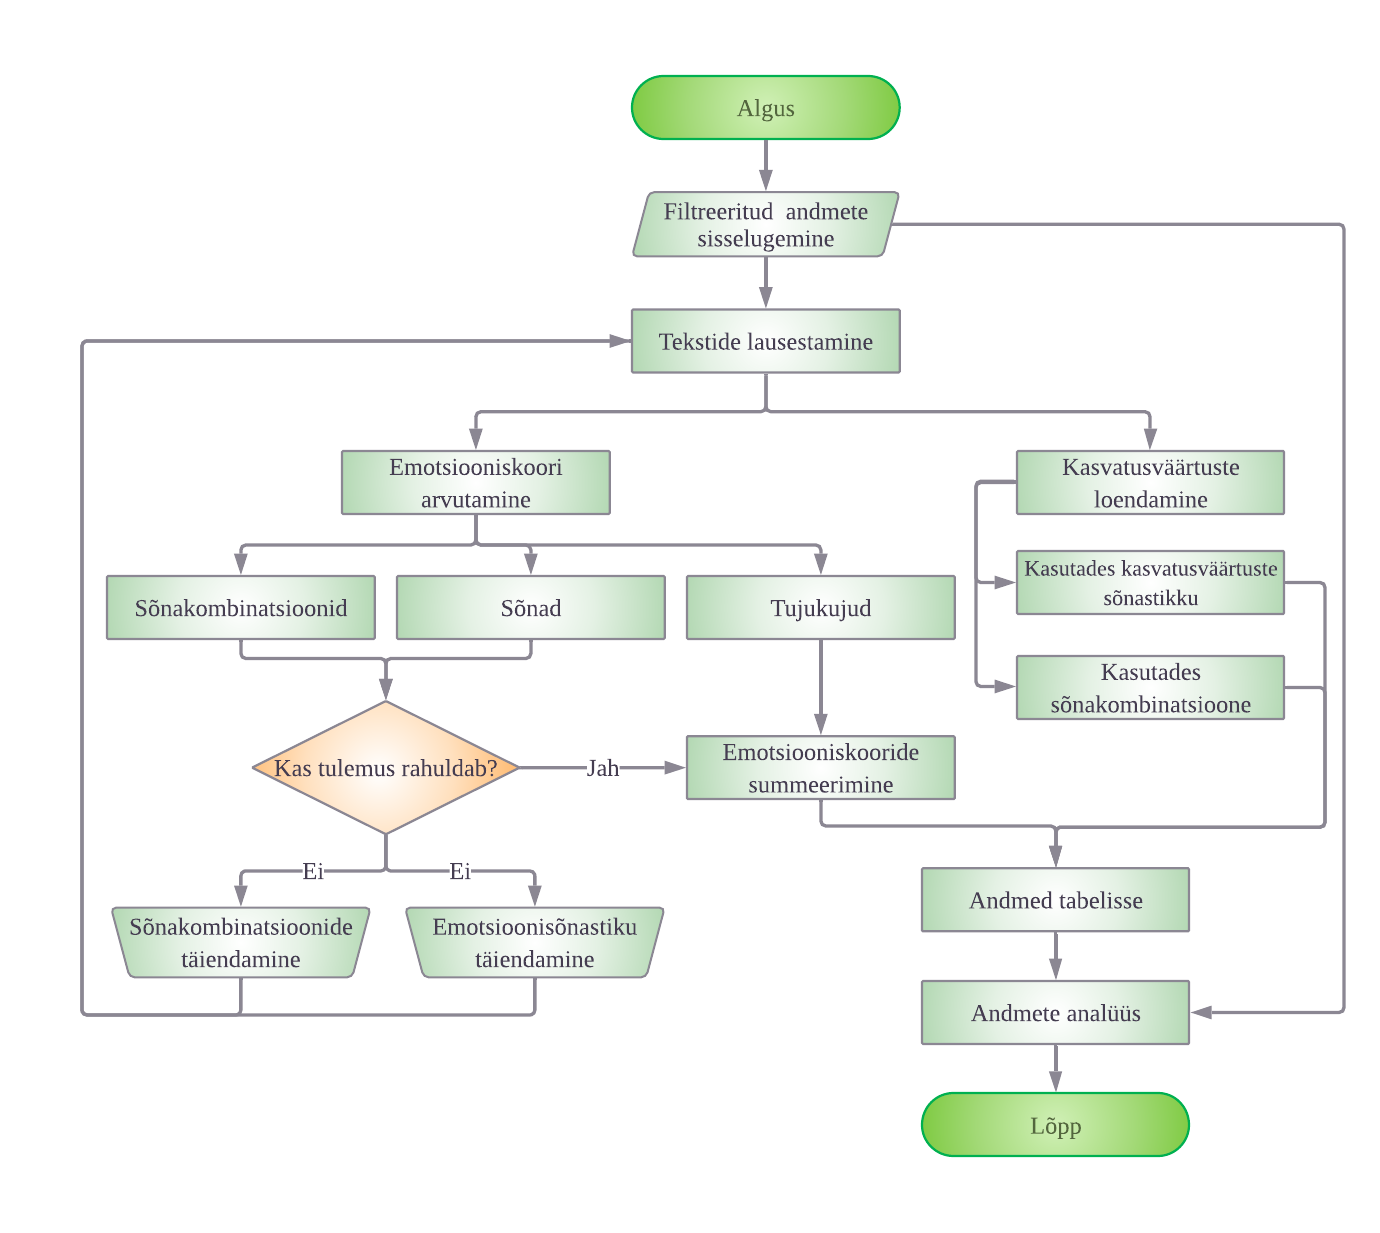

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "/magister/"
Image(filename = PATH + "emotsiooniskoor.png")

In [3]:
import re
import json
from collections import Counter
from collections import defaultdict
from estnltk import Text, Regex, Lemmas, Postags, Concatenation, Union, Gaps
import codecs
import csv
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
emo_uus = defaultdict(int)#Panen eestikeelsed sõnad sõnastikku, kus võtmeks sõna ja väärtuseks emotsioon
with codecs.open('emotsionaalsus_sonastik_mod.csv',encoding = "UTF-8"  ) as csv_file:
    rows = []    
    reader = csv.reader(csv_file,delimiter =',')
    header = next(reader)
    for row in reader: 
        sona = re.findall('\w\D+', str(row[0]))#eemaldan osade sõnade ees olevad küsimärgid
        sona_str =''.join(sona)#tagasi stringi kujule
        emo_uus[sona_str] = row[1]#lisan sõnad sõnastikku

In [5]:
trad = ['kuulekas','sõnakuulelik','töökas','ausus',
         'püüdlik','sõnakuulekas','hoolas','distsiplineeritud','kuulekus',
        'sõnakuulelikkus','austus', 'viisakus','töökus','püüdlikkus',
        'korralikkus','usinus','distsipliin','enesedistsipliin', 'austama',
        'vastutustunne','kohusetunne','kohusetundlik','austav','sõnakuulekus',
        'lugupidav','respekteeriv','hästikasvatatud','sõnapidaja','sõnapidamine',
        'kohusetruu','edasipüüdlikkus','korraarmastus','korraarmastaja',
        'distsiplineeritus','õppimistahe','andestav','abivalmis',
        'abivalmidus','isetu', 'isetus'
        ]

In [6]:
trad1_konformism=['kuulekas','sõnakuulelik','sõnakuulekas','distsiplineeritud',
                  'kuulekus','sõnakuulelikkus','austus','viisakus','korralikkus',
                  'distsipliin','enesedistsipliin','austama','austav','sõnakuulekus',
                  'lugupidav','respekteeriv','hästikasvatatud','korraarmastus',
                  'korraarmastaja','distsiplineeritus',
                  ]

In [7]:
trad2_koh_heatahtlik=['töökas','püüdlik','hoolas','töökus','püüdlikkus','usinus','vastutustunne',
                               'kohusetunne','kohusetundlik','kohusetruu','ausus','sõnapidaja',
                               'sõnapidamine','abivalmis','andestav','lojaalne','isetu','altruistlik'
                             ]

In [8]:
autonoomia =['enesekindlus','eneseusaldus','loovus','uudishimulikkus',
             'iseseisvus','ettevõtlikkus','eneseteadvus','eesmärgikindlus',
             'visadus','järjekindlus','sihikindlus','sitkus','loomingulisus',
             'enesekindel','loov','uudishimulik','iseseisev','ettevõtlik',
             'eneseteadlik','sihiteadlik','sihikindel',
             'teotahteline','tegus','algatusvõimeline','järjekindel',
             'loominguline','ambitsioonikas', 'sihiteadlik','saavutusvajadus',
             'algatusvõime','otsustamisjulgus','kreatiivne','kreatiivsus',
             'teadmisjanuline','edasipüüdlik'
         ]

In [9]:
autonoomia_looming=['enesekindlus','eneseusaldus','loovus','uudishimulikkus','iseseisvus',
                     'eneseteadvus','loomingulisus','enesekindel','loov','uudishimulik',
                     'iseseisev','eneseteadlik','loominguline','otsustamisjulgus','kreatiivne',
                     'kreatiivsus','teadmisjanuline','õppimistahe','sõltumatus','eneseaustus'
                    ]

In [10]:
autonoomia_saavutamine =['ettevõtlikkus','eesmärgikindlus','visadus','järjekindlus','sihikindlus',
                      'sitkus','ettevõtlik','sihiteadlik','järjekindel','sihikindel','teotahteline',
                      'tegus','algatusvõimeline','ambitsioonikas','sihiteadlik',
                      'saavutusvajadus','algatusvõime','edasipüüdlik','edasipüüdlikkus','eneseteostus'
                     ]

In [11]:
#loome grammatika jaoks nö ehitusklotsid
eitus_pos = Lemmas('ei', 'ega')
eitus = Lemmas('ei')
space = Regex('\s')
tegusona =Postags('V')
pole = Regex('pole')
polnud = Regex('polnud')

In [12]:
#grammatika eitusega positiivsete ja neutraalsete tegusõnade jaoks
pos_tegusonad = Lemmas('looma', 'lootma','lubama','lõhnama','meeldima',
                       'mõistma','naeratama','nautima','nõustuma','sobima',
                       'aitama','arenema','edenema','huvitama','julgema','kaitsma',
                       'kallistama','kindlustama','kasvama','kiitma','kinkima',
                       'lahendama','oskama','saavutama','armastama','armuma','arutlema',
                       'austama','hoolitsema','imetlema','jalutama','kasvama','parandama',
                       'paranema','puhkama','pääsema','päästma','rahuldama','rahustama',
                       'ravima','rõõmustama','taastama','tantsima','tervitama','toetama',
                       'tohtima','tugevdama','tunnustama','tähistama','tänama','unistama',
                       'usaldama','vabanema','vabastama','võitma','väärima','õitsema','õnnestuma',
                       'õnnitlema','üllatuma')
pole_tegusona =Concatenation(pole,tegusona, sep = space)
eitus_tegusona =Concatenation(eitus_pos,tegusona, sep = space)
pole_pos_tegusona =Concatenation(pole,pos_tegusonad, sep = space)
eitus_pos_tegusona = Concatenation(eitus_pos,pos_tegusonad, sep = space)
eitus_neutr_tegusona = Gaps(Union(pole_tegusona,eitus_tegusona, sep = space))
neg_pos_tegusona = Gaps(Union(pole_pos_tegusona,eitus_pos_tegusona, sep = space))

In [13]:
#grammatika eitusega negatiivsete tegusõnade jaoks
neg_tegusonad = Lemmas('matma','muretsema','mürgitama','nutma','ohustama',
                        'oksendama','nutma','lööma','peksma','närveerima',
                        'pahandama', 'petma','purunema','puuduma','põgenema',
                        'raiskama','rikkuma','riskima','röövima','ründama',
                        'segama','solvuma','suitsetama','sundima','surema',
                        'suruma', 'suudlema','sõdima','süüdistama','takistama',
                        'tapma','trügima','tulistama','tungima','tühistama',
                        'tülitama','tülitsema','unustama','vaidlema','valetama',
                        'vallandama','valutama','varastama','vigastama','vihkama',
                        'võitlema','väsima','ähvardama','kaotama','vahistama',
                        'kulutama','purustama','kuluma','liialdama','rõhuma',
                        'hävitama','õõnestama','politiseerima','ununema',
                        'ahistama','ärrituma','ärandama','karmistama',
                        'küüditama','vägistama','laimama','ehmatama','eitama',
                        'eksima','haisema','halvenema','hilinema','hirmutama',
                        'hukkuma','hõivama','häbenema','häirima','hämmastama',
                        'hävima','hävitama','iiveldama','kaebama','kahetsema',
                        'kahjustama','kahtlema','kannatama','kaotama','karistama',
                        'karjuma','kartma','katkestama','kaugenema','keelama',
                        'keelduma','kihutama','kiirustama','kritiseerima','kukkuma',
                        'kurtma','kurvastama','kärpima','käskima','köhima','lagunema',
                        'lahutama','lammutama','loobuma','loovutama','lõhkuma')

pole_neg_tegusona = Concatenation(pole,neg_tegusonad, sep = space)
eitus_neg_tegusona = Concatenation(eitus,neg_tegusonad, sep = space)
neg_neg_tegusona=Gaps(Union(pole_neg_tegusona,eitus_neg_tegusona))

In [14]:
#grammatika ksvatusväärtuste jaoks
nimisonad = Lemmas('käitumine', 'laps','õpilane', 'koolilaps','poiss',
                   'tüdruk','komme','kasvatus','kasvatamine')
olema = Lemmas('olema')
omadussonad_konformism =Lemmas('viisakas','korralik')
omadussonad_heatahtlik =Lemmas('aus') 
verb2 =Lemmas('kuulama')
verb4 =Lemmas('täitma')
nimisona2=Lemmas('sõna')
nimisona5=Lemmas('kohustus')
nimisona6=Lemmas('käsk')
viisakas_korralik_nimisonad=Concatenation(omadussonad_konformism,nimisonad, sep = space)
aus_nimisonad=Concatenation(omadussonad_heatahtlik,nimisonad, sep = space)
kuulama_sona = Concatenation(verb2, nimisona2, sep = space)
sona_kuulama =Concatenation(nimisona2, verb2, sep = space)
kohustus_taitma =Concatenation(nimisona5,verb4, sep = space)
kask_taitma =Concatenation(nimisona6,verb4, sep = space)
trad_konformism = Gaps(Union(kuulama_sona, sona_kuulama,kohustus_taitma,kask_taitma,viisakas_korralik_nimisonad ))
trad_heatahtlik = Gaps(aus_nimisonad)

In [15]:
puhas_jarjend =[] #loeme sisse andmed
with open('loplikult_puhastatud3.json') as f:
    for line in f:        
        uus_rida = json.loads(line)  
        puhas_jarjend.append(uus_rida)

In [16]:
for test in puhas_jarjend[:3]:#testime sisseloetud andmeid
    print(test) 

[1, '80353', 'Teismeliste käitumine.', '378813', '29.08.2013 16:56', 'Minu esimene mõte oli ka, et kas see teismeline ikka üldse märkas sind? Ma olen ise seda tüüpi, kes avalikes ja rahvarikastes kohtades on nii oma mullis, et kui just otsa ei kõnni, siis võin klaasistunud pilgul ka väga heast ja kallist tuttavast 20 cm kauguselt mööda kõndida ja teda mitte märgata. Ja nii jääbki tere ütlemata ning viisakuse puudumisega pole asjal mingit pistmist. ']
[2, '12554', 'Kuidas karistada kui 2kl. laps ei pane õppimisi kirja?', '361370', '13.03.2012 16:46', 'meile tegi õpetaja selgeks, et järgmise päeva õppimise ülesanded on lapsel kohustus kirjutada päevikusse, tema e-kooli ei kirjuta detailselt järgmise päeva õppimist ja mõned asjad võivad ilmuda tagantjärele. Esmalt peaksin mina lapsega maha tõsise vestluse, kus ta peaks ise analüüsima olukroda, siis las kirjeldab, mida ta tahab/ mis on tema jaoks oluline( sain aru, et hinded ei jäta teda ükskõikseks, sealt ka hoolsus ja tema kui õpilase ma

In [20]:
koik_andmed = []#arvutame ekotsiooniskoorid ja liidame kokku kasvatusväärtused
def andmed_dataframe(rida):
    tabelisse_andmed =[]    
    trad_vaartused = trad1_loe = trad2_loe  =0
    auton_vaartused = auton1_loe = auton2_loe = 0
    pos_emotik_arv = neg_emotik_arv =loe_lauseid = 0
    pos_neg_loe = float(0)
    trad1_skoor = trad2_skoor= auton1_skoor= auton2_skoor= 0
    emo_sonad_arv = 0
    pos_emotikon1 = ':)'#leiame tekstist emotikonid, mis on tühikutega eraldamata
    pos_emotikon2 = ';)'
    pos_emotikon3 = ':-)'
    neg_emotikon1 = ':('
    kuupaev=rida[4]
    teksti_id =rida[0]
    teema_id = rida[1]
    teema =rida[2]
    autor =rida[3]
    tekst =rida[5]
    myre_positiivsed = re.compile(u'['#positiivsed emotikonid ehk tujukujud
     u'\U0001F642'
     u'\U0001F604'
     u'\U0001F60A'
     u'\U0001F61B'
     u'\U0001F609'
     u'\U0001F600]+', 
     re.UNICODE)
    myre_negatiivsed = re.compile(u'['#negatiivne tujukuju
     u'\U0001F641]+', 
     re.UNICODE)
    tulemus =re.findall(myre_positiivsed, tekst)#leiame positiivsed tujukujud
    pos_emotik_arv = len(tulemus)
    pos_neg_loe += pos_emotik_arv
    tulemus2 =re.findall(myre_negatiivsed, tekst)#leiame negatiivsed tujukujud
    neg_emotik_arv = len(tulemus2)
    pos_neg_loe -= neg_emotik_arv
    tund = ' '.join(map(str,re.findall(r'\s\d+',kuupaev)))#leiame tunni
    aasta = ' '.join(map(str,re.findall(r'\d{4}',kuupaev)))#võtan kuupäevast välja aasta
    kuupaev_kellata = ' '.join(map(str,re.findall(r'\d{2}\.\d{2}\.\d{4}',kuupaev)))
    paev, kuu, aasta = (int(x) for x in kuupaev_kellata.split('.'))    
    date_kuupaev = date(aasta, kuu, paev)#teeme kuupäeva date formaati
    nadalapaev = date_kuupaev.strftime("%A")#leiame nädalapäeva
    sonade_arv = len(tekst.split())
    tahemarkide_arv = len(tekst)
    tekst = Text(tekst)
    for lause in tekst.split_by('sentences'):#teen teksid lauseteks, määran keele
        loe_lauseid +=1
        puhas_lause = lause['text']
        lemmad =Text(lause).lemmas
        for j in range(len(lause.words)):#käin laused üle sõnakaupa, et vaadata, kas on 
            word1 =lause['words'][j]#olemas vaste emotsioonisõnastikus
            sona =word1['text'].lower()
            if pos_emotikon1 in sona or pos_emotikon2 in sona or pos_emotikon3 in sona:
                pos_neg_loe +=1
                pos_emotik_arv +=1
                emo_sonad_arv +=1
            if neg_emotikon1 in sona:
                pos_neg_loe -=1
                neg_emotik_arv -=1
                emo_sonad_arv +=1
            if sona in emo_uus:#kui sõna on emotsioonisõnastikus, siis liidan või lahutan skoorile sõnastikus oleva väärtuse
                for k,v in emo_uus.items():
                    if k ==sona:
                        pos_neg_loe += int(v)
                        emo_sonad_arv +=1
        for j in range(len(lemmad)):#käin laused üle sõnakaupa
            sona =lemmad[j]
            if '|'in sona:#kui lemma jääb mitmeseks, siis lisame nimekirja esimesel kohal oleva sõnakuju
                nimekiri = list((sona).split('|'))                
                for sona in nimekiri:
                    if sona in trad1_konformism:#loeme kasvatusväärtusi                       
                        trad1_loe +=1 
                    if sona in trad2_koh_heatahtlik:                        
                        trad2_loe +=1                         
                    if sona in autonoomia_looming:
                        auton1_loe +=1    
                    if sona in autonoomia_saavutamine:
                        auton2_loe +=1                    
            else:
                if sona in trad1_konformism:#loeme kasvatusväärtusi                        
                    trad1_loe +=1 
                if sona in trad2_koh_heatahtlik:                        
                    trad2_loe +=1                         
                if sona in autonoomia_looming:
                    auton1_loe +=1    
                if sona in autonoomia_saavutamine:
                    auton2_loe +=1
        for match in trad_konformism.get_matches(lause):#grammatikaga kasvatusväärtuste lugemine
            trad1_loe +=1
        for match in trad_heatahtlik.get_matches(lause):
            trad2_loe +=1
        for match in neg_neg_tegusona.get_matches(lause):#grammatikaga emotsioonisõnade lugemine
            pos_neg_loe +=2.5
            emo_sonad_arv +=1
        for match in neg_pos_tegusona.get_matches(lause):
            pos_neg_loe -=1
            emo_sonad_arv +=1
        for match in eitus_neutr_tegusona.get_matches(lause):
            pos_neg_loe -=0.5
            emo_sonad_arv +=1
    trad_vaartused= trad1_loe + trad2_loe
    auton_vaartused =auton1_loe + auton2_loe
    tulemus = auton_vaartused - trad_vaartused
    if tulemus >=2:#jagame andmed väärtusjaotuse järgi
        vaartusjaotus = 'Autonoomsed 2+'
    elif tulemus >0 and tulemus <2:
        vaartusjaotus = 'Autonoomsed'
    elif tulemus ==0:
        vaartusjaotus = 'Võrdne'
    elif tulemus <0 and tulemus >-2:
        vaartusjaotus = 'Traditsioonilised'
    elif tulemus <=-2:
        vaartusjaotus = 'Traditsioonilised 2+'
    kaalutud_emotsioon =pos_neg_loe/sonade_arv
    if int(tund) >= 0 and int(tund) < 8: #jagame postitused kellaaja järgi kolmeks
        postitus_aeg_agr ='Öö'
    elif int(tund) >= 8 and int(tund) < 16:
        postitus_aeg_agr ='Päev'
    elif int(tund) >= 16 and int(tund) < 24:
        postitus_aeg_agr ='Õhtu'
    if pos_neg_loe >0:
        emo_skoor ="Positiivne"
    elif pos_neg_loe ==0:
        emo_skoor ="Neutraalne"
    elif pos_neg_loe <0:
        emo_skoor ="Negatiivne"
    tabelisse_andmed = [teksti_id,aasta,teema_id,autor, 
                        trad1_loe,trad2_loe,trad_vaartused,
                        auton1_loe,auton2_loe,auton_vaartused,
                        tulemus, pos_neg_loe,vaartusjaotus,
                        pos_emotik_arv,neg_emotik_arv, kaalutud_emotsioon,
                        sonade_arv, emo_sonad_arv,tund,
                        nadalapaev, postitus_aeg_agr, loe_lauseid,
                        tahemarkide_arv, emo_skoor]
    return tabelisse_andmed
for rida in puhas_jarjend:#loeme andmed sisse
    andmed = andmed_dataframe(rida)#kasutame funktsiooni 
    koik_andmed += [andmed]#liidame andmed järjendisse    

In [21]:
for rida in koik_andmed[:5]:#testime andmeid
    print(rida)

[1, 2013, '80353', '378813', 1, 0, 1, 0, 0, 0, -1, -1.5, 'Traditsioonilised', 0, 0, -0.0234375, 64, 4, ' 16', 'Thursday', 'Õhtu', 3, 382, 'Negatiivne']
[2, 2012, '12554', '361370', 1, 0, 1, 0, 0, 0, -1, -0.5, 'Traditsioonilised', 0, 0, -0.0023584905660377358, 212, 19, ' 16', 'Tuesday', 'Õhtu', 9, 1490, 'Negatiivne']
[3, 2016, '2341221', '372159', 1, 0, 1, 0, 0, 0, -1, 2.5, 'Traditsioonilised', 1, 0, 0.018796992481203006, 133, 19, ' 22', 'Thursday', 'Õhtu', 8, 816, 'Positiivne']
[4, 2012, '41359', '372464', 0, 1, 1, 0, 0, 0, -1, -0.5, 'Traditsioonilised', 0, 0, -0.008333333333333333, 60, 14, ' 09', 'Saturday', 'Päev', 4, 389, 'Negatiivne']
[5, 2013, '60866', '364383', 0, 0, 0, 1, 0, 1, 1, 0.5, 'Autonoomsed', 0, 0, 0.005208333333333333, 96, 15, ' 15', 'Tuesday', 'Päev', 5, 631, 'Positiivne']


In [22]:
with open('andmed_tabelisse.json', 'w') as fout:#kirjutame 
    for rida in koik_andmed: #andmed faili
        json.dump(rida,fout)
        fout.write('\n')